# Mask Detection Project

The objective of this project is to detect from pictures or live videos if the person is wearing a mask or not. This notebook is divided in three parts: building the dataset, training the model, evaluating the model. 

In [1]:
import torch 
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
classes = ['No-Mask', 'Mask']

# DATASET

## Collecting Data from folders

In [3]:
COLLECT_DATA = True

#Collect paths
if COLLECT_DATA: #if we are running it for the first time
    data_path = Path('data/train')
    maskPath = data_path/'mask'
    noMaskPath = data_path/'no_mask'
    path_dirs = [ [maskPath,1],[noMaskPath,0] ] #path and label
    if not os.path.exists(data_path):
        raise Exception("The data path doesn't exist")

#Define a class which will hold our data (each image of size 100x100 with a label)
class MaskOrNoMask():
    IMG_SIZE = 100
    LABELS = {'NO_MASK': 0, 'MASK': 1}
    training_data = []
    
    count = 0
    
    def collect_data(self):
        for data_dir, label in path_dirs:
            print('------------ Reading from: ',data_dir,' ------------')
            for imgpath in os.listdir(data_dir):
                    self.count += 1                       
                    img_path = os.path.join(data_dir, imgpath)
                    try:
                        img = cv2.imread(img_path)
                        img = cv2.resize(img, (self.IMG_SIZE,self.IMG_SIZE))
                        self.training_data.append([np.array(img), label])
                        self.count +=1
                        
                        if label == 1:
                            self.LABELS['MASK'] += 1
                        if label == 0:
                            self.LABELS['NO_MASK'] +=1
                            
                    except:
                         raise Exception('error: {}'.format(img_path))
            print(self.LABELS)
                       
        #Shuffle data as they were collected in order (mask, no mask) and save it
        np.random.shuffle(self.training_data)
        np.save(data_path/'npy/training_data.npy', self.training_data)
        
if COLLECT_DATA:
    maskOrNomask = MaskOrNoMask()
    maskOrNomask.collect_data()
    training_data = maskOrNomask.training_data
else:
    training_data = np.load('./npy/training_data.npy', allow_pickle=True)

------------ Reading from:  data/train/mask  ------------
{'NO_MASK': 0, 'MASK': 1150}
------------ Reading from:  data/train/no_mask  ------------
{'NO_MASK': 1711, 'MASK': 1150}


/home/abdou/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


------------ Example ----------------
Picture shape: (100, 100, 3)
Picture label: 0
Picture class: No-Mask
Picture:


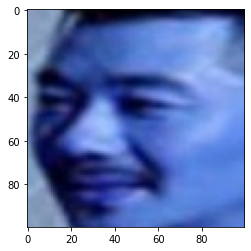

In [4]:
print('------------ Example ----------------')
print('Picture shape:',training_data[7][0].shape)
print('Picture label:',training_data[7][1])
print('Picture class:',classes[training_data[7][1]])
print('Picture:')
plt.imshow(training_data[7][0])

## Building the Dataset

In [5]:
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, ToTensor

In [6]:
#Define a class which will hold our dataset: (tensor(img), tensor(0|1))
class MaskDataset(Dataset):
        #Load the data and transform the images to tensor
    def __init__(self, train_data):
            self.train_data = train_data
            self.transformations = Compose([
                ToTensor()
        ])
        #Access a specific item of the dataset i.e. index
    def __getitem__(self, key):
            if isinstance(key, slice):
                raise NotImplementedError('Slicing is not supported')                    
            return [
                self.transformations(self.train_data[key][0]),
                torch.tensor(self.train_data[key][1]) 
            ]
        #Get the lengh of the dataset
    def __len__(self):
            return len(self.train_data)

In [7]:
#Build our dataset
myDataset = MaskDataset(training_data)

------------ Example ----------------
Label:  No-Mask
Shape: torch.Size([3, 100, 100])
Tensor: [tensor([[[0.2667, 0.2235, 0.2039,  ..., 0.4745, 0.4941, 0.4941],
         [0.2627, 0.2118, 0.1843,  ..., 0.4471, 0.4863, 0.5020],
         [0.2471, 0.2000, 0.1804,  ..., 0.4314, 0.4745, 0.4980],
         ...,
         [0.4549, 0.3059, 0.1882,  ..., 0.2667, 0.2510, 0.2431],
         [0.4039, 0.3333, 0.2000,  ..., 0.2627, 0.2510, 0.2549],
         [0.3529, 0.3294, 0.2157,  ..., 0.2588, 0.2471, 0.2549]],

        [[0.2392, 0.1843, 0.1333,  ..., 0.5176, 0.5608, 0.5608],
         [0.2314, 0.1647, 0.1098,  ..., 0.4902, 0.5490, 0.5686],
         [0.2118, 0.1529, 0.1098,  ..., 0.4706, 0.5294, 0.5529],
         ...,
         [0.4549, 0.2941, 0.1686,  ..., 0.2431, 0.2471, 0.2549],
         [0.4078, 0.3294, 0.1804,  ..., 0.2392, 0.2471, 0.2667],
         [0.3608, 0.3216, 0.1961,  ..., 0.2353, 0.2431, 0.2706]],

        [[0.1961, 0.1490, 0.1098,  ..., 0.5373, 0.5961, 0.6078],
         [0.1922, 0.1333, 0

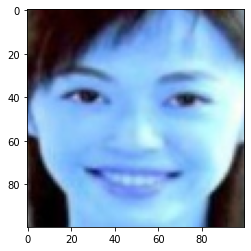

In [8]:
print('------------ Example ----------------')
print('Label: ',classes[int(myDataset[777][1].item())])
print('Shape:',myDataset[777][0].shape)
print('Tensor:', myDataset[777])
print('Picture:')
plt.imshow(myDataset[777][0].permute(1, 2, 0))

## Splitting and loading datasets

In [9]:
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid


In [10]:
#Split the dataset in two parts: 70% trainning and 30% validation
val_size = round(len(myDataset)*0.30)
train_size = len(myDataset) - val_size
trainset, valset = torch.utils.data.random_split(myDataset, [train_size, val_size])

#Split the validation dataset in two parts: 90% validation and 10% test
test_size= round(len(valset)*0.10)
val_size= len(valset) - test_size
testset, valset = torch.utils.data.random_split(valset, [test_size, val_size])

print('------------ Size of each set ----------------')
print('Training dataset:', len(trainset), 'pictures')
print('Validation dataset:', len(valset), 'pictures')
print('Test dataset:', len(testset), 'pictures')

------------ Size of each set ----------------
Training dataset: 2002 pictures
Validation dataset: 772 pictures
Test dataset: 86 pictures


In [11]:
#Construct the dataloader for each set
trainloader = DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=100,
                                         shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=20,
                                         shuffle=False, num_workers=2)

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
        break

------------ Example ----------------


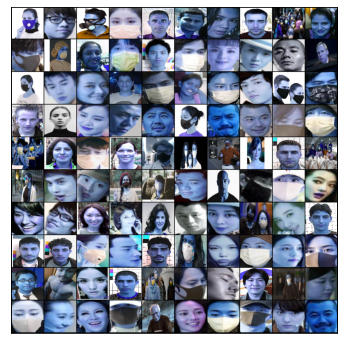

In [13]:
print('------------ Example ----------------')
show_batch(valloader)

# MODEL CNN

In [14]:
input_size = 100*100
output_size = 2

## Defining the model

In [15]:
#Build the CNN model
class MaskDetection(nn.Module):
    def __init__(self,n_classes=2):
        super(MaskDetection,self).__init__()
        self.conv1=nn.Conv2d(3, 100, kernel_size=3, padding=1)
        self.conv2=nn.Conv2d(100, 128, kernel_size=3, stride=1, padding=1)
            
        self.pool=nn.MaxPool2d(2, 2)
            
        self.conv3=nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4=nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1) 
            
        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(160000, 512))
        self.fc2=nn.Linear(512, 256)
        self.fc3=nn.Linear(256, n_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv2(F.relu(self.conv1(x))))) # output: 128 x 8 x 8
        x = self.pool(F.relu(self.conv4(F.relu(self.conv3(x))))) # output: 256 x 4 x 4
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [16]:
model = MaskDetection()
model.eval()

MaskDetection(
  (conv1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(100, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Sequential(
    (0): Flatten()
    (1): Linear(in_features=160000, out_features=512, bias=True)
  )
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

In [17]:
param=sum(p.numel() for p in model.parameters() if p.requires_grad)
print('------------ Number of trainable parameters ----------------')
print(param)

------------ Number of trainable parameters ----------------
83055730


## Setting device

In [18]:
def set_default_device():
    if torch.cuda.is_available():
        print('------------ CUDA ----------------')
        return torch.device('cuda')
    else:
        print('------------ CPU ----------------')
        return torch.device('cpu')

In [19]:
device = set_default_device()

------------ CPU ----------------


In [20]:
model.to(device)

MaskDetection(
  (conv1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(100, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Sequential(
    (0): Flatten()
    (1): Linear(in_features=160000, out_features=512, bias=True)
  )
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

## Training the model

In [21]:
# Define the training function (train and validate)
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs,device):
    
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        print("TRAINING MODEL")
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        print("EVALUATING MODEL")
        for batch in tqdm(val_loader):
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
                        
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.4f}'.format(epoch, training_loss,valid_loss, num_correct / num_examples))


In [22]:
#Define the test function
def test_model(model):
    true_labels = []
    predicted_labels = []

    for img, lab in testloader: # we iterate over the test dataset
        true_labels.append(lab.numpy())
        img, lab = img.to(device), lab.to(device)
        pred = model(img) # these are the "activations" corresponding to each class: the higher the activation, the more likely the class
        pred = nn.Softmax(dim=0)(pred) # these are the estimated probability of belonging to each class
        pred = pred.argmax(dim=1) # these are the most likely classes
        predicted_labels.append(pred.detach().cpu().numpy())

    true_labels = np.concatenate(true_labels)
    predicted_labels = np.concatenate(predicted_labels)
    print('Correct: {:d}  Total: {:.1f}'.format((true_labels == predicted_labels).sum(), true_labels.size))
    print('Accuracy: {:f}%'.format(100*(true_labels == predicted_labels).mean()))

In [50]:
# Choose optimizer and loss function
import torch.optim as optim

In [24]:
# Training Algorithm
while True:
    epochs = int(input("Enter the Number of Epochs: "))
    lr = float(input("Enter the Learning Rate: "))
    optimizer = optim.Adam(model.parameters(), lr)
    loss = torch.nn.CrossEntropyLoss()
    train(model, optimizer, loss, trainloader, valloader, epochs,device)
    test_model(model)
    choice = input("Do you want to save the trained model? (y/n): ")
    if(choice == 'y'):
        torch.save(model, "modelf.pth")
        break
    else:
        choice = input("Want to Run More Epochs? (y/n): ")
        if(choice=='y'):
            continue
        else:
            choice = input("Press Enter to Close ")
            break   

Enter the Number of Epochs: 5
Enter the Learning Rate: 0.001


  0%|          | 0/21 [00:00<?, ?it/s]

TRAINING MODEL


  0%|          | 0/8 [00:00<?, ?it/s]

EVALUATING MODEL


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 0, Training Loss: 0.7939, Validation Loss: 0.6392, accuracy = 0.6023
TRAINING MODEL


  0%|          | 0/8 [00:00<?, ?it/s]

EVALUATING MODEL


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.3497, Validation Loss: 0.2943, accuracy = 0.8977
TRAINING MODEL


  0%|          | 0/8 [00:00<?, ?it/s]

EVALUATING MODEL


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.2306, Validation Loss: 0.1938, accuracy = 0.9365
TRAINING MODEL


  0%|          | 0/8 [00:00<?, ?it/s]

EVALUATING MODEL


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.1731, Validation Loss: 0.1792, accuracy = 0.9249
TRAINING MODEL


  0%|          | 0/8 [00:00<?, ?it/s]

EVALUATING MODEL


100%|██████████| 8/8 [00:57<00:00,  7.22s/it]


Epoch: 4, Training Loss: 0.1616, Validation Loss: 0.2618, accuracy = 0.9313
Correct: 84  Total: 86.0
Accuracy: 97.674419%
Do you want to save the trained model? (y/n): y


# EVALUATION

## Confusion matrix

In [25]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
def test_model_values(model):
    true_labels = []
    predicted_labels = []

    for img, lab in testloader: # we iterate over the test dataset
        true_labels.append(lab.numpy())
        img, lab = img.to(device), lab.to(device)
        pred = model(img) # these are the "activations" corresponding to each class: the higher the activation, the more likely the class
        pred = nn.Softmax(dim=0)(pred) # these are the estimated probability of belonging to each class
        pred = pred.argmax(dim=1) # these are the most likely classes
        predicted_labels.append(pred.detach().cpu().numpy())

    true_labels = np.concatenate(true_labels)
    predicted_labels = np.concatenate(predicted_labels)
    return true_labels, predicted_labels

In [28]:
true_labels, predicted_labels=test_model_values(model)
cm = confusion_matrix(true_labels, predicted_labels)

Normalized confusion matrix
[[0.96296296 0.03703704]
 [0.         1.        ]]


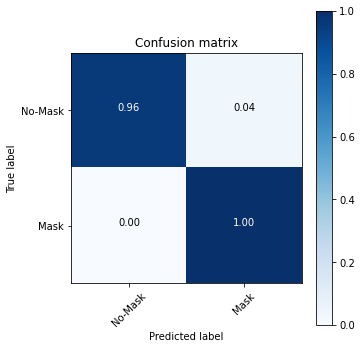

In [29]:
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm, classes)

In [48]:
def get_stats(cm):
    acc=round(100*(cm[1][1]+cm[0][0])/(cm[0][0]+cm[1][0]+cm[0][1]+cm[1][1]),2)
    prec=round(100*cm[1][1]/(cm[1][1]+cm[0][1]),2)
    rec=round(100*cm[1][1]/(cm[1][1])+cm[1][0],2)
    print('Accuracy: ',acc, '%')
    print('Precision: ', prec, '%')
    print('Recall: ', rec, '%')


In [49]:
get_stats(cm)

Accuracy:  97.67 %
Precision:  94.12 %
Recall:  100.0 %


## Image test

In [35]:
import matplotlib.image as mpimg
def image_test(path, label= None, show= False):
    img = cv2.imread(path)
    assert img is not None,"Image wasn't read properly"
    img = cv2.resize(img, (100, 100))
    img = torch.from_numpy(img)
    img = img.permute((2, 0,1)) # model expects image to be of shape [3, 100, 100]
    img = img.unsqueeze(dim=0).float() # convert single image to batch [1, 3, 100, 100]
    img = img.to(device)
    pred = model(img) 
    preds=torch.max(F.softmax(pred, dim=1), dim=1)[1]
    print(classes[preds.item()])

    if show:
        plt.imshow(mpimg.imread(path))
        print("the image is :" + classes[preds.item()])

------------ Example ----------------
Mask
the image is :Mask


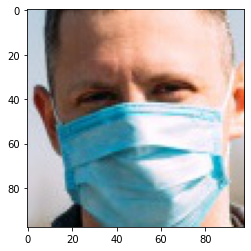

In [36]:
print('------------ Example ----------------')
image_test('data/test/mask/Masked_3.jpg', show=True)

## Video test

Download the folder Video_Test: https://drive.google.com/drive/folders/1wOR7zxtUgvylGEatkWGSV7444-wA9fHt?usp=sharing

Use the terminal to launch the py file.